# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Init

In [3]:
import datahandler

import matplotlib.pyplot as plt


dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:24<00:00,  4.08s/it]


# Plot

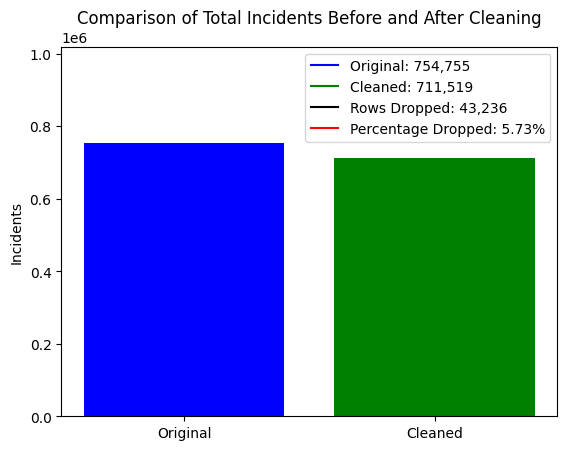

In [4]:
rows_df1 = data_loader.processed_incidents_df.shape[0]
rows_df2 = data_loader.enhanced_incidents_df.shape[0]
rows_dropped = rows_df1 - rows_df2
drop_percentage = (rows_dropped / rows_df1) * 100

# Data
labels = ['Original', 'Cleaned']
values = [rows_df1, rows_df2]

# Plot
fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['blue', 'green'])

# Adjust y-axis limits to provide space for the legend
ax.set_ylim(0, max(values) * 1.35)  # Extending the y-axis by 15%

# Add details to legend
handles, labels = ax.get_legend_handles_labels()
labels.append(f'Original: {rows_df1:,}')
labels.append(f'Cleaned: {rows_df2:,}')
labels.append(f'Rows Dropped: {rows_dropped:,}')
labels.append(f'Percentage Dropped: {drop_percentage:.2f}%')
# Assigning specific colors for the legend placeholders
handles.extend([
    plt.Line2D([0], [0], color='blue'),
    plt.Line2D([0], [0], color='green'),
    plt.Line2D([0], [0], color='black'),
    plt.Line2D([0], [0], color='red')
])

ax.legend(handles=handles, labels=labels)

plt.ylabel('Incidents')
plt.title('Comparison of Total Incidents Before and After Cleaning')
plt.show()
